In [18]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.framework import ops

image_summary = tf.summary.image
scalar_summary = tf.summary.scalar
histogram_summary = tf.summary.histogram
merge_summary = tf.summary.merge
SummaryWriter = tf.summary.FileWriter

# Helper functions:
1. Linear (Creates a fully connected layer)
2. Conv2D (Creates a convolution layer)
3. Deconv2D (Creates a deconvolution layer)

## Linear args:
    
    input_: tensor to compose. Shape: [N, M]
    output_size: number of output neurons
    scope: name scope
    stddev: standard deviation of gaussian distribution to use for random weight initialization
    name: name scope
    with_w: whether to also return parameter variables
    
__N : Number of samples.__

__M : Number of features on input.__

In [19]:
def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):

    shape = input_.get_shape().as_list()
    
    with tf.variable_scope(scope or "Linear"):
        #If Matrix does not exits on scope, create a new variable
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                                 tf.random_normal_initializer(stddev=stddev))
        #If bias does not exits on scope, create a new variable
        bias = tf.get_variable("bias", [output_size],
            initializer=tf.constant_initializer(bias_start))
        #Return tensor with layer result and their weigths and bias
        if with_w:
            return tf.matmul(input_, matrix) + bias, matrix, bias
        else:
            return tf.matmul(input_, matrix) + bias

## Conv2D args:

    input_: tensor to compose. Shape: [N, H, W, C]
    output_dim: number of output features maps (activation)
    k_h: kernel height
    k_w: kernel width
    d_h: horizontal stride
    d_w: vertical stride
    stddev: standard deviation of gaussian distribution to use for random weight initialization
    name: name scope

__N: Number of samples.__

__H W C : Number of features on input (Height, Width, Channel).__

In [20]:
def conv2d(input_, output_dim, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="conv2d"):

    with tf.variable_scope(name):
        #Depth of filter is equal to input depth and output_dim gives the depth of next layer
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
                            initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')

        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.nn.bias_add(conv, biases)

        return conv

## Deconv2D args:

    input_: tensor to compose. Shape: [N, H, W, C]
    output_shape: output shape
    k_h: kernel height
    k_w: kernel width
    d_h: horizontal stride
    d_w: vertical stride
    stddev: standard deviation of gaussian distribution to use for random weight initialization
    name: name scope

__N: Number of samples.__

__H W C : Number of features on input (Height, Width, Channel).__

In [21]:
def deconv2d(input_, output_shape, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="deconv2d", with_w=False):

    with tf.variable_scope(name):
        # filter : [height, width, output_channels, in_channels]
        w = tf.get_variable('w',
                            [k_h, k_w, output_shape[-1],
                            input_.get_shape()[-1]],
                            initializer=tf.random_normal_initializer(stddev=stddev))
        deconv = tf.nn.conv2d_transpose(input_, w,
                                        output_shape=output_shape,
                                        strides=[1, d_h, d_w, 1])

        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), output_shape)

        if with_w:
            return deconv, w, biases
        else:
            return deconv

## Activation function:
### Leak Relu

In [22]:
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

## Batch Normalization:
    This class creates an op that composes the specified tensor with a batch normalization layer.
### Args:
    x: tensor to compose
    train: set to True during training and False otherwise

In [23]:
class batch_norm(object):

    def __init__(self, epsilon=1e-5, momentum=0.9, name="batch_norm"):
        
        with tf.variable_scope(name):
            self.epsilon = epsilon
            self.momentum = momentum
            self.name = name

    def __call__(self, x, train=True):
        
        return tf.contrib.layers.batch_norm(x,
                                            decay=self.momentum,
                                            updates_collections=None,
                                            epsilon=self.epsilon,
                                            scale=True,
                                            is_training=train,
                                            scope=self.name)

# Create model:




### Config model (Default):
    output_size: (optional) The resolution in pixels of the images. [64]    
    z_dim: (optional) Dimension of dim for Z. [100]
    gf_dim: (optional) Dimension of gen filters in first conv layer. [64]
    df_dim: (optional) Dimension of discrim filters in first conv layer. [64]
    gfc_dim: (optional) Dimension of gen units for for fully connected layer. [1024]
    dfc_dim: (optional) Dimension of discrim units for fully connected layer. [1024]
    c_dim: (optional) Dimension of image color. For grayscale input, set to 1. [3]
    is_training: whether this is a training graph
    is_inference: whether this graph is created for inference/testing
    x: input node. Shape: [N, H, W, C]
    y: label. Shape: [N] for scalar labels, [N, H, W, C] otherwise. (Only defined if self._is_training is True)

In [24]:
class Model():
    
    def __init__(self, x):
        
        self.x = x
        
        image_size = 64
        output_size = 64
        c_dim = 3
        z_dim = 100

        self.dcgan_init(image_size=image_size, output_size=output_size, c_dim=c_dim, z_dim=z_dim)

    def inference(self):
        """op to use for inference"""

        # scale back to [0, 255] range
        return tf.to_int32((self.G+127) * 128)

    def loss(self):
        """
        Loss function

        Returns either an op or a list of dicts.
        If the returned value is an op then DIGITS will optimize against this op
        with respect to all trainable variables.
        If the returned value is a list then DIGITS will optimize against each
        loss in the list with respect to the specified variables.
        """

        # here we are returning a list because we want to alternately optimize the
        # discriminator and the generator.

        losses = [
            {'loss': self.d_loss, 'vars': self.d_vars},
            {'loss': self.g_loss, 'vars': self.g_vars}
        ]
        return losses

In [25]:
    def dcgan_init(self,image_size,output_size,z_dim,c_dim,gf_dim=64,df_dim=64,gfc_dim=1024,dfc_dim=1024):

        self.image_size = image_size
        self.output_size = output_size

        self.z_dim = z_dim

        self.gf_dim = gf_dim
        self.df_dim = df_dim

        self.gfc_dim = gfc_dim
        self.dfc_dim = dfc_dim

        self.c_dim = c_dim

        self.batch_size = tf.shape(self.x)[0]

        self.soft_label_margin = 0.1
        
        # batch normalization : deals with poor initialization helps gradient flow
        self.d_bn1 = batch_norm(name='d_bn1')
        self.d_bn2 = batch_norm(name='d_bn2')
        self.d_bn3 = batch_norm(name='d_bn3')

        self.g_bn0 = batch_norm(name='g_bn0')
        self.g_bn1 = batch_norm(name='g_bn1')
        self.g_bn2 = batch_norm(name='g_bn2')
        self.g_bn3 = batch_norm(name='g_bn3')
        
        self.build_model()

## D network:
    returns probability that image came from dataset -> D(x)
### args:
    - input - [N, 64, 64, 3]
    - conv layer with 64 5x5 kernels and 2x2 stride - [N, 32, 32, 64]
    - leaky relu - [N, 32, 32, 64]
    - conv layer with 128 5x5 kernels and 2x2 stride - [N, 16, 16, 32]
    - batch norm - [N, 16, 16, 32]
    - leaky relu - [N, 16, 16, 32]
    - conv layer with 256 5x5 kernels and 2x2 stride - [N, 8, 8, 256]
    - batch norm - [N, 8, 8, 256]
    - leaky relu - [N, 8, 8, 256]
    - conv layer with 256 5x5 kernels and 2x2 stride - [N, 4, 4, 512]
    - batch norm - [N, 4, 4, 512]
    - leaky relu - [N, 4, 4, 512]
    - flatten - [N, 8192]
    - linear layer with 1 output neurons - [N, 1]
    - sigmoid - [N,1]

In [26]:
    #Make foward on a batch of images
    def discriminator(self, image, y=None, reuse=False):

        #Get N value
        batch_size = image.get_shape().as_list()[0]

        with tf.variable_scope("discriminator") as scope:
            if reuse:
                scope.reuse_variables()

            #0º layer is a conv layer 64 features maps
            h0 = lrelu(conv2d(image, self.df_dim, name='d_h0_conv'))
            
            #1º layer is a conv layer 128 features maps
            h1 = lrelu(self.d_bn1(conv2d(h0, self.df_dim * 2, name='d_h1_conv'), train=self.is_training))
            
            #2º layer is a conv layer 256 features maps
            h2 = lrelu(self.d_bn2(conv2d(h1, self.df_dim * 4, name='d_h2_conv'), train=self.is_training))
            
            #3º layer is a conv layer 512 features maps
            h3 = lrelu(self.d_bn3(conv2d(h2, self.df_dim * 8, name='d_h3_conv'), train=self.is_training))
            
            #Calculate size for flatten 2D layer (64/16)^2 = 4^2 = 16, 16*64*8 = 8192
            h3_size = ((self.output_size // 16) ** 2) * self.df_dim * 8
            
            #4º layer is a flatten(512@4x4 to 8192 neurows) Fully connected a neuron that will be D(x) value
            h4 = linear(tf.reshape(h3, [self.batch_size, h3_size]), 1, 'd_h4_lin')

            return tf.nn.sigmoid(h4), h4

## G foward:
    returns generated image -> G(z)
### args:
    - input - [N, 100]
    - linear layer with 8192 output neurons - [N, 8192]
    - reshape - [N, 4, 4, 512]
    - batch norm - [N, 4, 4, 512]
    - relu - [N, 4, 4, 512]
    - transpose convolution with 256 filters and stride 2 - [N, 8, 8, 256]
    - batch norm - [N, 8, 8, 256]
    - relu - [N, 8, 8, 256]
    - transpose convolution with 128 filters and stride 2 - [N, 16, 16, 128]
    - batch norm - [N, 16, 16, 128]
    - relu - [N, 16, 16, 128]
    - transpose convolution with 64 filters and stride 2 - [N, 32, 32, 64]
    - batch norm - [N, 32, 32, 64]
    - relu - [N, 32, 32, 64]
    - transpose convolution with 3 filters and stride 2 - [N, 64, 64, 3]
    - tanh - [N, 64, 64, 3]

In [27]:
    #Make foward on a batch of z's
    def generator(self, z, y=None):


        with tf.variable_scope("generator") as scope:

            # 64 is the output size
            s = self.output_size

            # Layers sizes 32,16,8,4
            s2, s4, s8, s16 = int(s // 2), int(s // 4), int(s // 8), int(s // 16)

            #First layer is a fullyconnected layer
            self.z_, self.h0_w, self.h0_b = linear(z, self.gf_dim * 8 * s16 * s16, 'g_h0_lin', with_w=True)

            #Transform 1D layer in 2D layer because the next layer, this process is called feature maps
            self.h0 = tf.reshape(self.z_, [-1, s16, s16, self.gf_dim * 8])
            h0 = tf.nn.relu(self.g_bn0(self.h0, train=self.is_training))

            #1º deconv(conv_transpose) layer [Samples, 8, 8, 256]
            self.h1, self.h1_w, self.h1_b = deconv2d(h0,
                [self.batch_size, s8, s8, self.gf_dim * 4], name='g_h1', with_w=True)
            h1 = tf.nn.relu(self.g_bn1(self.h1, train=self.is_training))

            #2º deconv(conv_transpose) layer [Samples, 16, 16, 128]
            h2, self.h2_w, self.h2_b = deconv2d(h1,
                [self.batch_size, s4, s4, self.gf_dim * 2], name='g_h2', with_w=True)
            h2 = tf.nn.relu(self.g_bn2(h2, train=self.is_training))

            #3º deconv(conv_transpose) layer [Samples, 32, 32, 34]
            h3, self.h3_w, self.h3_b = deconv2d(h2,
                [self.batch_size, s2, s2, self.gf_dim * 1], name='g_h3', with_w=True)
            h3 = tf.nn.relu(self.g_bn3(h3, train=self.is_training))

            #4º deconv(conv_transpose) layer [Samples, 64, 64, 3]
            h4, self.h4_w, self.h4_b = deconv2d(h3,
                [self.batch_size, s, s, self.c_dim], name='g_h4', with_w=True)

            return tf.nn.tanh(h4)

In [28]:
    def build_model(self):

        if not self.is_inference:
            # create both the generator and the discriminator
            # self.x is a batch of images - shape: [N, H, W, C]
            # self.y is a vector of labels - shape: [N]

            # sample z from a normal distribution
            self.z = tf.random_normal(shape=[self.batch_size, self.z_dim], dtype=tf.float32, seed=None, name='z')

            # scale input to [-1, +1] range
            self.images = (tf.reshape(self.x,
                                      shape=[self.batch_size,
                                             self.image_size,
                                             self.image_size,
                                             self.c_dim],
                                      name='x_reshaped') - 128)/ 127.

            # create generator
            self.G = self.generator(self.z)
            # create an instance of the discriminator (real samples)
            self.D, self.D_logits = self.discriminator(self.images, reuse=False)
            # create another identical instance of the discriminator (fake samples)
            # NOTE: we are re-using variables here to share weights between the two
            # instances of the discriminator
            self.D_, self.D_logits_ = self.discriminator(self.G, reuse=True)

            # we are using the cross entropy loss for all these losses
            # note the use of the soft label smoothing here to prevent D from getting overly confident
            # on real samples
            self.d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(self.D_logits,
                                              tf.ones_like(self.D) - self.soft_label_margin,
                                              name="loss_D_real"))
            self.d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(self.D_logits_,
                                              tf.zeros_like(self.D_),
                                              name="loss_D_fake"))
            self.d_loss = (self.d_loss_real + self.d_loss_fake) / 2.
            # the typical GAN set-up is that of a minimax game where D is trying to minimize its own error and G is trying to maximize D's error
            # however note how we are flipping G labels here: instead of maximizing D's error, we are minimizing D's error on the 'wrong' label
            # this trick helps produce a stronger gradient
            self.g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(self.D_logits_,
                                              tf.ones_like(self.D_) + self.soft_label_margin,
                                              name="loss_G"))

            # debug
            self.summaries.append(image_summary("G", self.G, max_outputs=3))
            self.summaries.append(image_summary("X", self.images, max_outputs=3))
            self.summaries.append(histogram_summary("G_hist", self.G))
            self.summaries.append(histogram_summary("X_hist", self.images))
            self.summaries.append(scalar_summary("d_loss_real", self.d_loss_real))
            self.summaries.append(scalar_summary("d_loss_fake", self.d_loss_fake))
            self.summaries.append(scalar_summary("g_loss", self.g_loss))
            self.summaries.append(scalar_summary("d_loss", self.d_loss))

            # all trainable variables
            t_vars = tf.trainable_variables()
            # G variables
            self.g_vars = [var for var in t_vars if 'g_' in var.name]
            # D variables
            self.d_vars = [var for var in t_vars if 'd_' in var.name]

            # Extra hook for debug: log chi-square distance between G's output histogram and the dataset's histogram
            value_range = [0.0, 1.0]
            nbins = 100
            hist_g = tf.histogram_fixed_width(self.G, value_range, nbins=nbins, dtype=tf.float32) / nbins
            hist_images = tf.histogram_fixed_width(self.images, value_range, nbins=nbins, dtype=tf.float32) / nbins
            chi_square = tf.reduce_mean(tf.div(tf.square(hist_g - hist_images), hist_g + hist_images + 1e-5))
            self.summaries.append(scalar_summary("chi_square", chi_square))
        else:
            # Create only the generator
            self.x = tf.reshape(self.x, shape=[self.batch_size, self.z_dim])
            self.z = self.x[:, :self.z_dim]
            self.G = self.generator(self.z)

# Load Dataset (Toy example)

##     Generate normal distribution

In [29]:
class DataDistribution(object):
    def __init__(self):
        self.mu = 4
        self.sigma = 0.5

    def sample(self, N):
        samples = np.random.normal(self.mu, self.sigma, N)
        samples.sort()
        return samples

class GeneratorDistribution(object):
    def __init__(self, rang):
        self.rang = rang

    def sample(self, N):
        return np.linspace(-self.rang, self.rang, N) + \
            np.random.random(N) * 0.01

In [30]:
data = DataDistribution()
printer = GeneratorDistribution(100)
x = printer.sample(100)
y = data.sample(10000)

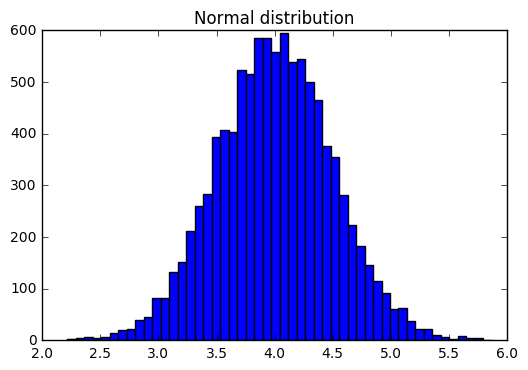

In [31]:
plt.hist(y,50)
plt.title('Normal distribution')
plt.show()

In [32]:
m = Model(y)

AttributeError: Model instance has no attribute 'dcgan_init'